<h1><center>Preprocessing</center></h1>

В този notebook ще направим лека трансформация на данните преди да преминем към създаването на модел. 
Dataset-ът се намира тук: 
https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics 

Нека заредим и разгледаме данните.

In [17]:
import numpy as np
import pandas as pd
import cld2
import matplotlib.pyplot as plt

In [9]:
# Dataset
dataset = pd.read_csv("lyrics.csv")
print(dataset.shape)
dataset.info()

(362237, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 6 columns):
index     362237 non-null int64
song      362235 non-null object
year      362237 non-null int64
artist    362237 non-null object
genre     362237 non-null object
lyrics    266557 non-null object
dtypes: int64(2), object(4)
memory usage: 16.6+ MB


Очаква се един изпълнител да прави песни главно в един жанр. Колоната year не изглежда много полезна за конкретния проблем (би била полезна за проблем като през коя година какви текстове/думи са по-популярни). Все пак искаме да познаме жанр по-генерално само по текст затова от данните ще оставим само колоните lyrics, genre. 

In [10]:
dataset = dataset.drop(columns=["artist", "year", "song", "index"])
dataset["lyrics"] = dataset['lyrics'].str.replace('\n', ' ')
dataset.head()

,genre,lyrics
0,Pop,"Oh baby, how you doing? You know I'm gonna cut..."
1,Pop,"playin' everything so easy, it's like you seem..."
2,Pop,If you search For tenderness It isn't hard to ...
3,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a..."
4,Pop,"Party the people, the people the party it's po..."


Можем да забележим, че има доста песни, чиито текстове или са празни или подобни на \[INSTRUMENTAL\](тоест нямат текст, само музика), или като цяло са много кратки. Затова ще ги премахнем.



In [11]:
dataset['words'] = dataset["lyrics"].apply(lambda s: len(str(s).split()))

dataset = dataset[(dataset["words"] >= 100)]
new_length = len(dataset)
print("New data length: " + str(new_length))

New data length: 229298


Text(20, 20, '[148.57]')

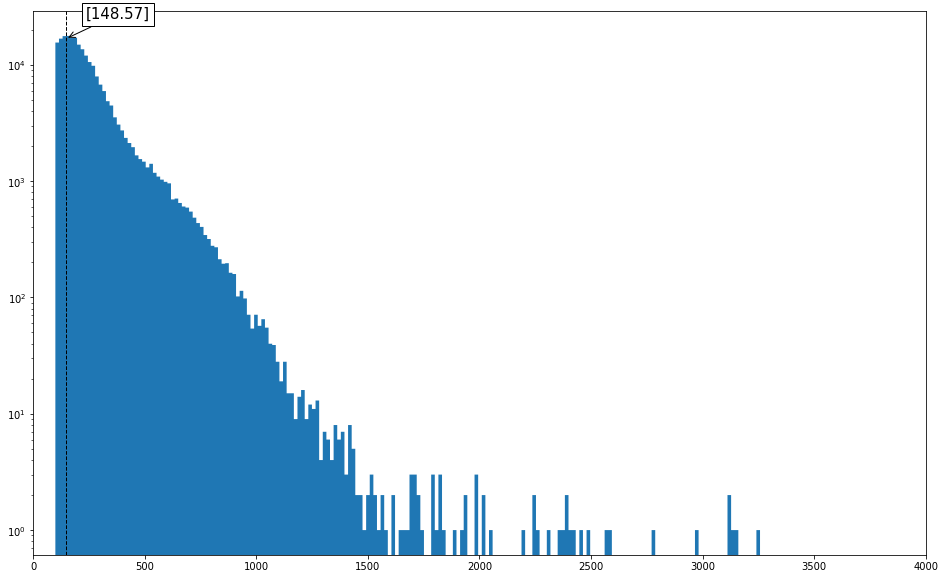

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

n, b, _ = ax.hist(dataset['words'], histtype='stepfilled', bins = 500)

bin_max = np.where(n == n.max())
peak = b[bin_max]

ax.axvline(peak, color='black', linestyle='dashed', linewidth=1)
plt.xlim(0, 4000)

plt.gca().set_yscale("log")

ax.annotate(str(peak), (peak, 16800), xytext=(20, 20), size=15,
                    textcoords='offset points',
                    bbox={'facecolor':'white'},
                    arrowprops={'arrowstyle':'->'})

In [15]:
print("Mean of song length: %0.3f" % np.mean(dataset.words))
print("Median of song length: %0.3f" % np.median(dataset.words))

Mean of song length: 254.303
Median of song length: 211.000


Очаквано, песни, които са от жанр хип-хоп и рок са най-дългите.

In [12]:
dataset[dataset.words >= 1500].groupby('genre').size()

genre
Electronic        1
Folk              1
Hip-Hop          36
Metal             3
Not Available     3
Other             1
Pop               2
Rock             22
dtype: int64

In [26]:
notavail = dataset[dataset["genre"] == "Not Available"]
notavail.head()

,genre,lyrics,words
350,Not Available,Santa Claus was scootin'across the roof tops '...,172
385,Not Available,Ist das so schwer ein kleines Lächeln wenn du ...,109
386,Not Available,Der Weg den du und ich gegangen führt mit eine...,175
387,Not Available,Rote Schatten warf das Feuer hell wie Gold war...,114
388,Not Available,"Willst Du mit mir gehn,Wenn mein Weg in Dunkel...",179


Друго, което трябва да забележим е, че има текстове, които не са на английски език. Те ще вкарат много шум в работата на модела. Пример са някои от текстовете от жанр Not Available. Ще го премахнем.
За премахването на останалите текстове не на английски ще изполваме https://pypi.org/project/cld2-cffi/, понеже имаме много данни и изглежда, че има приличен performance.

In [5]:
dataset = dataset[dataset["genre"] != "Not Available"]
print(len(dataset))
def remove_non_english(dataset):
    for index, row in dataset.iterrows():
        lyrics = row["lyrics"]
        if not(lyrics.isprintable()):
            dataset.drop(index=index, inplace=True)
            continue
            
        a, b, details = cld2.detect(lyrics)
        
        lang = details[0]
        if not(lang.language_code == "en" and lang.percent > 90):
            dataset.drop(index=index, inplace=True)
    
    return dataset

dataset = remove_non_english(dataset)
dataset.drop("words", axis=1, inplace=True)
dataset.to_csv("reduced.csv")

209345
